# Местоположение нефтяной скважины

**Исходные данные:** 
синтетические данные с пробами нефти и характеристиками скважин по трем регионам


**Цель:**
построить модель линейной регрессии для определения наиболее прибыльного по добыче региона, проанализировать возможную прибыль и риски с помощью Bootstrap



**Этапы исследования:**

1.   Загрузка исходных данных и их общая оценка, построение гистограмм для каждого столбца с числовыми значениями
2. Обучение и проверка модели для каждого региона (разделение датасета 75:25, метрика RMSE)
3. Подготовка данных к расчету прибыли. Расчет объема сырья для безубыточной разработки скважины.
4. Расчет прибыли по скважинам с максимальными значениями предсказаний:
    * Суммировать целевое значение объёма сырья, соответствующее этим предсказаниям
    * Рассчитать прибыль для полученного объёма сырья.
Посчитать риски и прибыль для каждого региона:
    * Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    * Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков

5. Заключение


## 1 Загрузка исходных данных

In [1]:
!pip install --upgrade matplotlib --quiet install

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  df_0 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_0.csv")
  df_1 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_1.csv")
  df_2 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_2.csv")
except:
  df_0 = pd.read_csv("geo_data_0.csv")
  df_1 = pd.read_csv("geo_data_1.csv")
  df_2 = pd.read_csv("geo_data_2.csv")

In [4]:
# function for primary analysis of data with non-normal distribution
# Kendall correlation
def df_info(df):
    # numeric and non-numeric for histograms and statistic info
    df_num = df.select_dtypes("number")
    # the columns number
    length = len(df.columns)
    # correlation method for heatmap
    meth_corr = "kendall"
    # how to split the statistic info for numeric columns
    split_show = 8
    # display 2 digits after the decimal point

    # change labels of columns
    df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower())
    try:
        for name in df.select_dtypes("number").columns:
            df[name] = pd.to_numeric(df[name], downcast="integer"
                                    if df[name].dtype == "int" else "float")
    finally:
        print("The type left the same as before")


    print('\033[94m  \033[1m {:^24s}'.format("General information"))
    info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
    info_0.loc["columns", ""] = length
    info_0.loc["row", ""] = len(df)
    info_0.loc["memory_usage, MB", ""] = df.memory_usage().sum() / (1024 ** 2)
    display(info_0)
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format("Deep information"))
    info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
    for col in df:
        if (pd.api.types.is_numeric_dtype(df[col])) and df[col].min() == 0:
            info_1.loc[col, "null_row"] = df.loc[df[col] == 0, col].count()
        else:
            info_1.loc[col, "null_row"] = 0
    info_1["uniq"] = df.nunique()
    info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
    info_1["dup_row"] = df.duplicated().sum()
    info_1["NaN"] = df.isna().sum()
    info_1["NaN,%"] = df.isna().sum() / 100
    info_1["type"] = df.dtypes
    info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
    info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
    info_1.fillna("", inplace=True)
    prop = {
        "border": "0.5px solid black",
        "width": "85px",
        "text-align": "center"
    }
    percent = {
        "NaN,%":"{:.2%}",
        "mean":"{:.3}",
        "std":"{:.3}",
        "min":"{:.3}",
        "25%":"{:.3}",
        "50%":"{:.3}",
        "75%":"{:.3}",
        "max":"{:.3}",
    }

    display(info_1.style.format(percent).set_properties(**prop))
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format(
        "Distribution of data in numeric columns"
        )
    )
    fig = plt.figure(figsize=(12,6))
    sfigs = fig.subfigures(round(length/4), 4)
    for i, axes in enumerate(sfigs.flat):
      try:
        axes.suptitle(df_num.columns[i])
        if len(df.iloc[:,i]) > 0:
          ax_1= axes.subplots(2, 1, sharex=True,
                              gridspec_kw={"height_ratios": (.15, .85)})
          sns.boxplot(data=df, x=df_num.columns[i], orient="h", ax=ax_1[0])
          sns.histplot(data=df, x=df_num.columns[i], kde=True, ax=ax_1[1])
          plt.xlabel("")
          plt.ylabel("")
      except:
        break
    plt.show()
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format(f"Correlation of {meth_corr}"))
    plt.figure(figsize=(length, length))
    sns.heatmap(df.corr(method=meth_corr), annot=True, linewidths=0.3,
                cmap='coolwarm', square=True)
    plt.show()


The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99990,10,0,0,0.00%,object,,,,,,,
f0,100000,0,99885,115,0,0,0.00%,float32,0.5,0.872,-1.41,-0.0726,0.502,1.07,2.36
f1,100000,0,99878,122,0,0,0.00%,float32,0.25,0.504,-0.848,-0.201,0.25,0.701,1.34
f2,100000,0,99885,115,0,0,0.00%,float32,2.5,3.25,-12.1,0.288,2.52,4.72,16.0
product,100000,1,99730,270,0,0,0.00%,float32,92.5,44.3,0.0,56.5,91.8,1.29e+02,1.85e+02




   Distribution of data in numeric columns


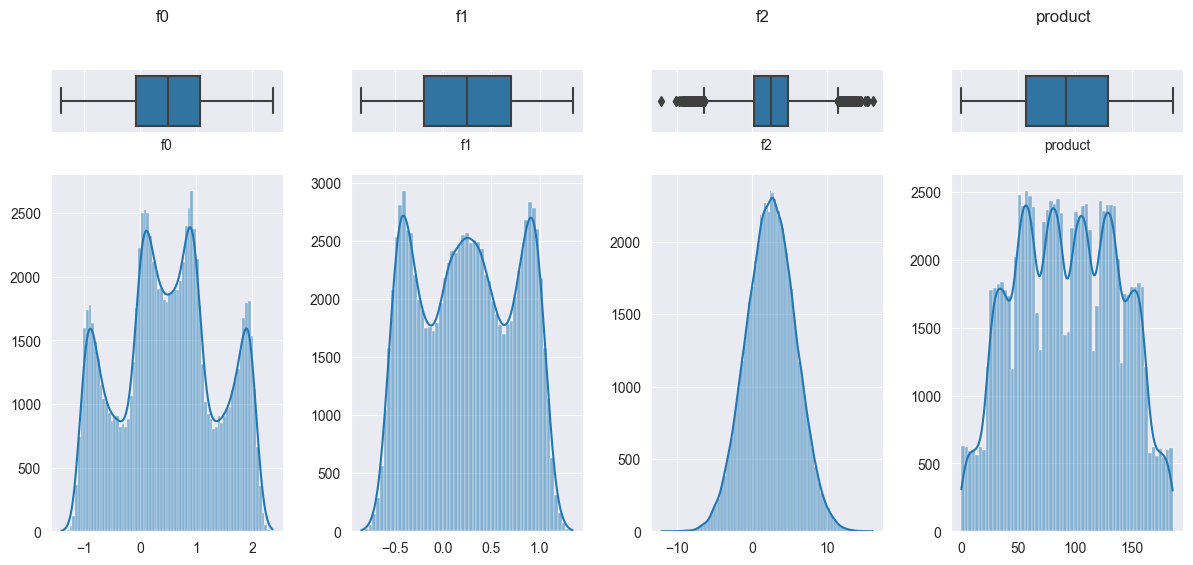



    Correlation of kendall 


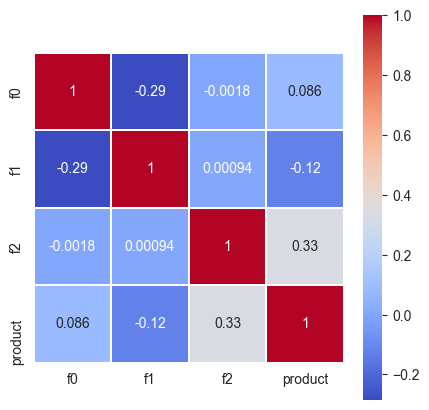

In [5]:
df_info(df_0)

The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99996,4,0,0,0.00%,object,,,,,,,
f0,100000,0,99902,98,0,0,0.00%,float32,1.14,8.97,-31.6,-6.3,1.15,8.62,29.4
f1,100000,0,99872,128,0,0,0.00%,float32,-4.8,5.12,-26.4,-8.27,-4.81,-1.33,18.7
f2,100000,0,90695,9305,0,0,0.00%,float32,2.49,1.7,-0.0181,1.0,2.01,4.0,5.02
product,100000,8235,12,99988,0,0,0.00%,float32,68.8,45.9,0.0,27.0,57.1,1.08e+02,1.38e+02




   Distribution of data in numeric columns


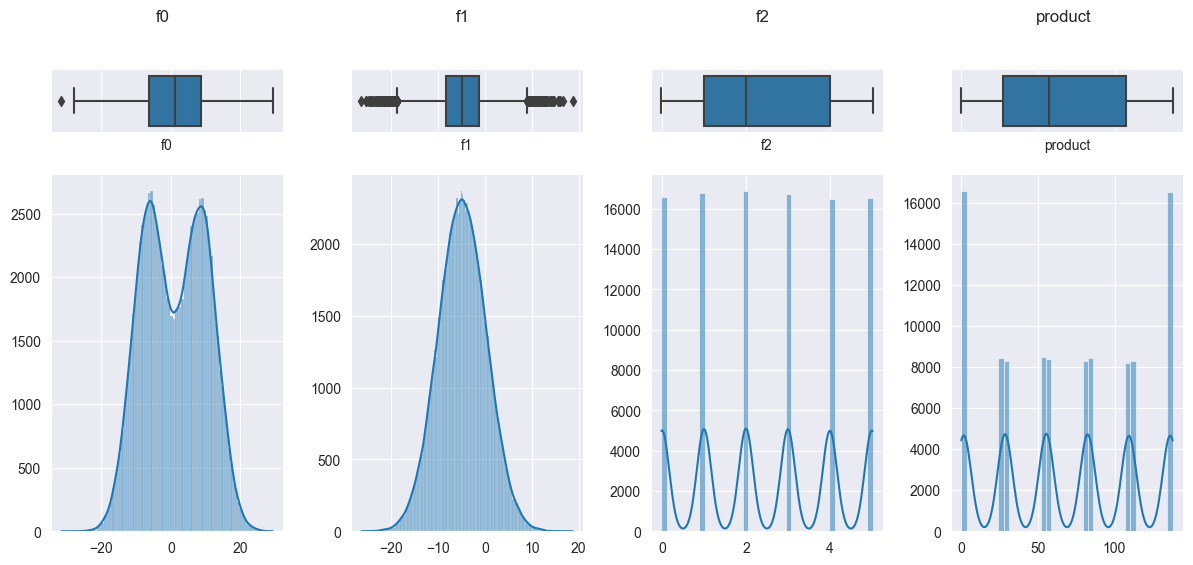



    Correlation of kendall 


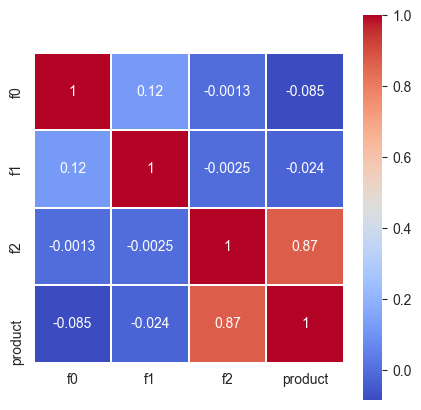

In [6]:
df_info(df_1)

The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99996,4,0,0,0.00%,object,,,,,,,
f0,100000,0,99922,78,0,0,0.00%,float32,0.00202,1.73,-8.76,-1.16,0.00942,1.16,7.24
f1,100000,0,99944,56,0,0,0.00%,float32,-0.00208,1.73,-7.08,-1.17,-0.00948,1.16,7.84
f2,100000,0,99896,104,0,0,0.00%,float32,2.5,3.47,-12.0,0.13,2.48,4.86,16.7
product,100000,1,99725,275,0,0,0.00%,float32,95.0,44.7,0.0,59.5,94.9,1.31e+02,1.9e+02




   Distribution of data in numeric columns


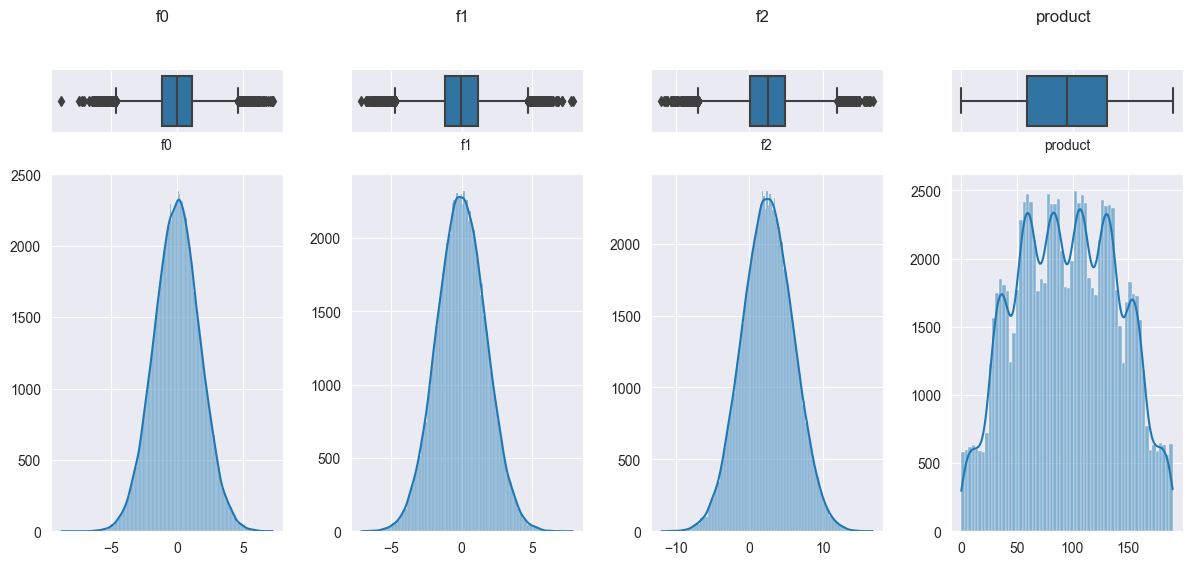



    Correlation of kendall 


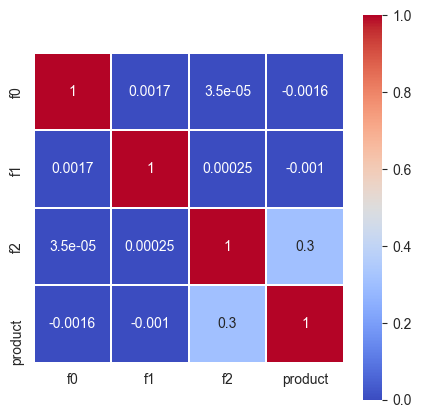

In [7]:
df_info(df_2)

In [8]:
df_0[df_0.id.duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828690
41724,bxg6G,-0.823752,0.546319,3.630479,93.007797
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020206
63593,QcMuo,0.635635,-0.473422,0.862670,64.578674
66136,74z30,1.084962,-0.312358,6.990771,127.643326
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964020
90815,fiKDv,0.049883,0.841313,6.394613,137.346588
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637299


In [9]:
df_1[df_1.id.duplicated()]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038887
82873,wt4Uk,10.259973,-9.376355,4.994297,134.766312
84461,5ltQ6,18.213839,2.191999,3.993869,107.813042
